### Linearised Koopman based on least square solution

In [932]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from GymEnvGenerator import RecordTrajGenerator

In [933]:
traj_num = 50
RTG = RecordTrajGenerator(200, traj_num)
sample_traj = next(RTG)
x = []
y = []
u = []
traj = sample_traj[0].numpy()
act = sample_traj[1].numpy()
for i in range(traj_num):
    t_ = traj[i]
    u_ = act[i]
    x.append(t_[:-1,:])
    y.append(t_[1:,:])
    u.append(u_[:-1,:])
    
X = np.array(x).reshape(3,-1)
Y = np.array(y).reshape(3,-1)
U = np.array(u).reshape(1,-1)

In [934]:
X.shape

(3, 9950)

### Feature transformation

In [935]:
import casadi

In [997]:
x = casadi.SX.sym('x', 4, 1)
fea = x
for i in np.linspace(0.1,2*np.pi,5):
    cos_f = casadi.cos(i * x)
    sin_f = casadi.sin(i * x)
    fea = casadi.vertcat(fea, cos_f)
    fea = casadi.vertcat(fea, sin_f)
    
for i in range(4):
    for j in range(4):
        poly = x[i] * x[j]
        fea = casadi.vertcat(fea, poly)

In [998]:
diff_x = casadi.jacobian(fea, x[0:3])
diff_u = casadi.jacobian(fea, x[3])

diff_x_f = casadi.Function('diff_f', [x], [diff_x])
diff_u_f = casadi.Function('diff_f', [x], [diff_u])
fea_f = casadi.Function('diff_f', [x], [fea])

## Linear Koopman

In [999]:
G = 0
A = 0
f_X = []
for i in range(X.shape[1]-1):
    feature_0 = fea_f(np.concatenate([X[:, i], U[:, i]])).full()
    feature_1 = fea_f(np.concatenate([X[:, i+1], U[:, i+1]])).full()
    G += feature_0 @ feature_0.T
    A += feature_0 @ feature_1.T
G *= 1/X.shape[1]
A *= 1/X.shape[1]

In [1000]:
K = np.linalg.pinv(G) @ A

In [1001]:
K.shape

(60, 60)

In [1017]:
A_sym = K[:,:3].T @ diff_x
B_sym = K[:,:3].T @ diff_u

A_func = casadi.Function('A', [x], [A_sym])
B_func = casadi.Function('B', [x], [B_sym])

### validating

In [1018]:
test_traj = next(RTG)
traj = test_traj[0].numpy()
act = test_traj[1].numpy()
test_x = traj[0]
test_u = act[0]
test_x.shape

(200, 3)

In [1020]:
x0 = test_x[0:1,:].T
res = []
for i in range(200):
    ut = test_u[i,:].reshape(-1,1)
    x_sym = np.concatenate([x0, ut])
    res.append(x0)
    
    A_ = A_func(x_sym).full()
    B_ = B_func(x_sym).full()
    
    x0 = A_ @ x0 +  B_ @ ut

/home/jiayun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in matmul
  # This is added back by InteractiveShellApp.init_path()


In [1021]:
res = np.array(res)

In [1022]:
res = res.squeeze()

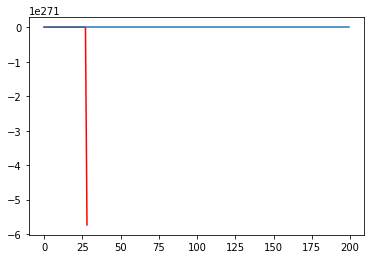

L2 loss: nan


In [1023]:
plt.plot(res[:,1], '-r')
plt.plot(test_x[:,1])
plt.show()
Loss = np.linalg.norm(test_x-res)
print("L2 loss: {}".format(Loss))